In [1]:
from collections import Counter
from functools import partial
import copy

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import spacy
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

sns.set(rc={'figure.figsize':(10,10)})
SEED = 42

In [2]:
def set_seed(seed):
    """
    Fixa semente aleatória para garantir que os resultados possam ser reproduzidos
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    
def tokenize (text, tok):
    return [token.text for token in tok.tokenizer(text)]

def encode_sentence(text, vocab2index, tok, N=1000):
    # tokenize text
    tokenized = tokenize(text, tok)
    # generate vector of size N filled with zeros
    encoded = np.zeros(N, dtype=int)
    # get encode for each word in text, if word not in vocab2index return UNK encode = 1
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    # sentence length
    length = min(N, len(enc1))
    # if the sentence length is less than N, the extra spaces will be filled with zeros.
    encoded[:length] = enc1[:length]
    return encoded, length

In [3]:
class load_data(torch.utils.data.Dataset):
    """
    Classe auxiliar para utilização do DataLoader
    """
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # word_embedding, label, document length
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [4]:
def split_data(df_data, fold):
    X = df_data.loc[df_data['fold'] == fold, 'four_pages_encoded'].values
    y = df_data.loc[df_data['fold'] == fold, 'label_int'].values
    
    return X, y

def encode_data(df_data, config):
    tok = spacy.load('pt_core_news_sm')

    # count frequency of each word    
    counts = Counter()
    for index, row in df_data.loc[df_data['fold']=="train"].iterrows():
        counts.update(tokenize(row['four_pages_processed'], tok))

    #creating vocabulary
    vocab2index = {"":0, "UNK":1}
    words = ["", "UNK"]
    for word in counts:
        vocab2index[word] = len(words)
        words.append(word)
        
    vocab_size = len(words)

    # encoding
    df_data['four_pages_encoded'] = None
    df_data.loc[df_data['fold'] == 'train','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'train','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    df_data.loc[df_data['fold'] == 'val','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'val','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    df_data.loc[df_data['fold'] == 'test','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'test','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    
    return df_data, vocab_size, vocab2index

In [5]:
def calculate_metrics(y_true, y_pred):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    return acc, f1_macro, f1_weighted

In [6]:
import torch
from torch import nn
from typing import List
import os
import json



class LSTM(nn.Module):
    """
    Bidirectional LSTM running over word embeddings.
    """
    def __init__(self, embedding_matrix, word_embedding_dimension: int, hidden_dim: int, num_layers: int = 1, num_classes: int = 13, vocab_size: int = 0, dropout: float = 0, bidirectional: bool = True):
        nn.Module.__init__(self)
        self.config_keys = ['word_embedding_dimension', 'hidden_dim', 'num_layers', 'dropout', 'bidirectional']
        self.word_embedding_dimension = word_embedding_dimension
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.vocab_size = vocab_size

        self.embeddings_dimension = hidden_dim
        if self.bidirectional:
            self.embeddings_dimension *= 2
            
        self.embeddings = nn.Embedding(vocab_size, word_embedding_dimension, padding_idx=0)
        self.embeddings.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embeddings.weight.requires_grad=False
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.LSTM(word_embedding_dimension, int(word_embedding_dimension/2), num_layers=num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(int(word_embedding_dimension/2), num_classes)
        #self.linear = nn.Linear(self.hidden_dim*4 , 64)
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(dropout)
        #self.out = nn.Linear(64, num_classes)
        
        #self.dropout = nn.Dropout(dropout)
        #self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, features, sentence_length):
        #token_embeddings = features['token_embeddings']
        #sentence_lengths = torch.clamp(features['sentence_lengths'], min=1)
        x = self.embeddings(features)
        x = self.dropout(x)
        #packed = nn.utils.rnn.pack_padded_sequence(x, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.encoder(x)
        ht[-1] = self.dropout(ht[-1])
        out = self.linear(ht[-1])
        #avg_pool = torch.mean(out_pack, 1)
        #max_pool, _ = torch.max(out_pack, 1)
        #conc = torch.cat(( avg_pool, max_pool), 1)
        #conc = self.relu(self.linear(conc))
        #conc = self.dropout(conc)
        #out = self.out(conc)
        return out

    def get_word_embedding_dimension(self) -> int:
        return self.embeddings_dimension

    def tokenize(self, text: str) -> List[int]:
        raise NotImplementedError()

    def save(self, output_path: str):
        with open(os.path.join(output_path, 'lstm_config.json'), 'w') as fOut:
            json.dump(self.get_config_dict(), fOut, indent=2)

        torch.save(self.state_dict(), os.path.join(output_path, 'pytorch_model.bin'))

    def get_config_dict(self):
        return {key: self.__dict__[key] for key in self.config_keys}

    @staticmethod
    def load(input_path: str):
        with open(os.path.join(input_path, 'lstm_config.json'), 'r') as fIn:
            config = json.load(fIn)

        weights = torch.load(os.path.join(input_path, 'pytorch_model.bin'))
        model = LSTM(**config)
        model.load_state_dict(weights)
        return model

In [7]:
def data_load(config, df_data):
    # Split data
    X_train, y_train = split_data(df_data, "train")
    X_val, y_val = split_data(df_data, "val")
    X_test, y_test = split_data(df_data, "test")
    
    # Load dataset
    train_set = load_data(X_train, y_train)
    val_set = load_data(X_val, y_val)
    test_set = load_data(X_test, y_test)
    
    data_loaders = dict()

    data_loaders["train"] = torch.utils.data.DataLoader(
        train_set,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    data_loaders["val"] = torch.utils.data.DataLoader(
        val_set,
        batch_size=int(config["batch_size"]),
        shuffle=False,
        num_workers=8)
    data_loaders["test"] = torch.utils.data.DataLoader(
        test_set,
        batch_size=int(config["batch_size"]),
        shuffle=False,
        num_workers=8)
    
    return data_loaders

In [8]:
def plot_confusion_matrix(y_pred, y_true, fold, labels_dict):
    ticks = copy.deepcopy(y_pred)
    ticks.extend(y_true)
    print(set(ticks))
    print(labels_dict)
    ticks = [labels_dict[tick] for tick in set(ticks)]
    
    cm = sns.heatmap(
        confusion_matrix(y_true, y_pred,normalize="true"),
        annot=True,
        center=0,
        vmin=0,
        vmax=1,
        square=True,
        fmt=".2f",
        xticklabels=ticks,
        yticklabels=ticks,
    )
    plt.yticks(rotation=0)
    img_name = "Confusion Matrix - {}".format(fold)
    plt.title(img_name)
    plt.show()

In [9]:
def train_model(config, checkpoint_dir=None, data_loaders=None, embedding_matrix = None):
    train_loader = data_loaders["train"]
    val_loader = data_loaders["val"]
    
    model = LSTM(
        embedding_matrix = embedding_matrix,
        word_embedding_dimension = config["embedding_dim"], 
        hidden_dim = config["embedding_dim"], 
        num_classes = config["num_classes"], 
        vocab_size = config["vocab_size"],
        num_layers = config["num_layers"], 
        dropout = config["dropout"], 
        bidirectional = True
    )
        
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.to(device)
    
    best_model = copy.deepcopy(model)
    best_loss = float("inf")
    #best_macro = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    """if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)"""
        
    for epoch in range(config["num_epochs"]):  # loop over the dataset multiple times
        print("="*20,"Epoch: {}".format(epoch+1), "="*20)
        model.train()
        training_loss = 0.0
        epoch_steps = 0
        y_pred = []
        y_true = []
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, sentence_length = data
            inputs, labels = inputs.long().to(device), labels.long().to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs, sentence_length)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_steps += 1
            training_loss += loss.cpu().detach().numpy()
            
            _, predicted = torch.max(outputs.data, 1)
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
            
        train_metrics = [(training_loss/epoch_steps)]
        train_metrics.extend(calculate_metrics(y_true, y_pred))
        
        print("Train:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]))

        val_metrics = eval_model(model, val_loader, device=device)
        print("Val:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f \n" % (
        val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]))
        
        #if val_metrics[2] > best_macro:
        if val_metrics[0] < best_loss:
            best_loss = val_metrics[0]
            best_model = copy.deepcopy(model)
            best_macro = val_metrics[2]
            path = os.path.join(checkpoint_dir, "model_v2_2.pth")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        elif val_metrics[0] == np.nan:
            val_metrics[0] = 10
    print("Finished Training")
    return best_model

In [10]:
def eval_model(model, loader, fold=None, labels_dict = None, device="cpu"):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    steps = 0
    sum_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            inputs, labels, sentence_length = data
            inputs, labels = inputs.long().to(device), labels.long().to(device)
            outputs = model(inputs, sentence_length)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            
            steps += 1
            sum_loss += loss.cpu().detach().numpy()
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
    
    metrics = [(sum_loss/steps)]
    metrics.extend(calculate_metrics(y_true, y_pred))
    if fold:
        plot_confusion_matrix(y_pred, y_true, fold, labels_dict)
    return metrics

In [11]:
def create_embedding_matrix(word_index,dimension):
    df_emb = pd.read_csv("./lstm_data/modelo_w2v_vec600_wd10_ct5_tec1.txt", header=None, sep = " ", index_col=0)
    #df_emb = pd.read_csv("./lstm_data/skip_s600.txt", header=None, sep = " ", index_col=0, skiprows=1)

    embedding_dict = {key: val.values for key, val in df_emb.T.items()}
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 2.449, accuracy 0.386, F1-Macro 0.051, F1-Weighted 0.248
Val:
 loss 2.533, accuracy 0.131, F1-Macro 0.026, F1-Weighted 0.030 

==================== Epoch: 2 ====================
Train:
 loss 1.859, accuracy 0.424, F1-Macro 0.046, F1-Weighted 0.253
Val:
 loss 2.549, accuracy 0.131, F1-Macro 0.026, F1-Weighted 0.030 

==================== Epoch: 3 ====================
Train:
 loss 1.568, accuracy 0.453, F1-Macro 0.074, F1-Weighted 0.300
Val:
 loss 2.356, accuracy 0.173, F1-Macro 0.067, F1-Weighted 0.079 

==================== Epoch: 4 ====================
Train:
 loss 1.300, accuracy 0.565, F1-Macro 0.144, F1-Weighted 0.450
Val:
 loss 2.370, accuracy 0.277, F1-Macro 0.134, F1-Weighted 0.151 

==================== Epoch: 5 ====================
Train:
 loss 1.101, accuracy 0.661, F1-Macro 0.248, F1-Weighted 0.589
Val:
 loss 2.185, accuracy 0.235, F1-Macro 0.121, F1-Weighted 0.137 

==================== Epoch: 6 ===============

==================== Epoch: 44 ====================
Train:
 loss 0.156, accuracy 0.960, F1-Macro 0.916, F1-Weighted 0.960
Val:
 loss 0.611, accuracy 0.806, F1-Macro 0.584, F1-Weighted 0.792 

==================== Epoch: 45 ====================
Train:
 loss 0.154, accuracy 0.956, F1-Macro 0.909, F1-Weighted 0.956
Val:
 loss 0.617, accuracy 0.814, F1-Macro 0.576, F1-Weighted 0.802 

==================== Epoch: 46 ====================
Train:
 loss 0.150, accuracy 0.960, F1-Macro 0.916, F1-Weighted 0.960
Val:
 loss 0.580, accuracy 0.842, F1-Macro 0.719, F1-Weighted 0.839 

==================== Epoch: 47 ====================
Train:
 loss 0.151, accuracy 0.959, F1-Macro 0.914, F1-Weighted 0.959
Val:
 loss 0.592, accuracy 0.838, F1-Macro 0.731, F1-Weighted 0.843 

==================== Epoch: 48 ====================
Train:
 loss 0.152, accuracy 0.959, F1-Macro 0.913, F1-Weighted 0.959
Val:
 loss 0.490, accuracy 0.846, F1-Macro 0.628, F1-Weighted 0.839 

==================== Epoch: 49 =========

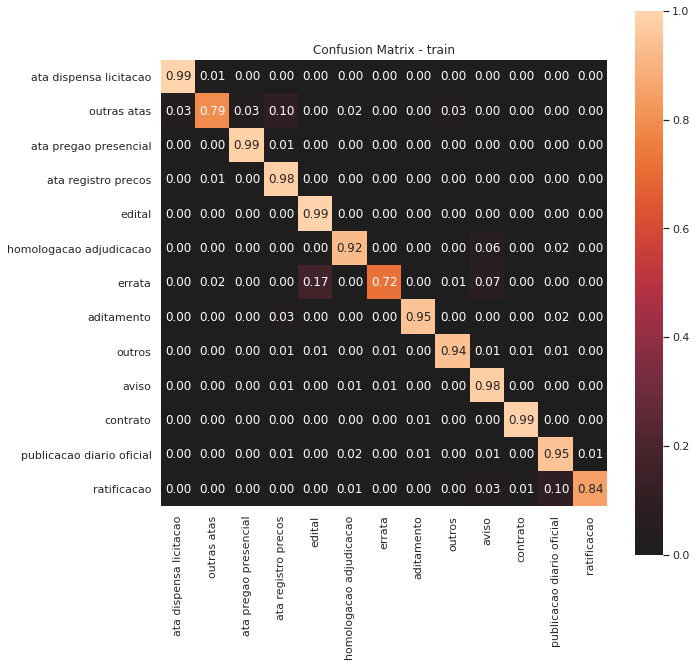

Train:
 loss 0.126, accuracy 0.967, F1-Macro 0.930, F1-Weighted 0.967
{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


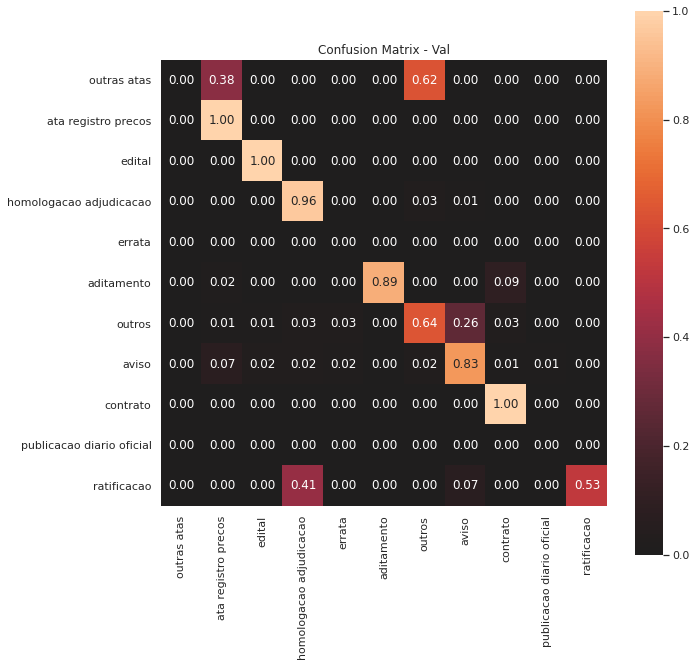

Val:
 loss 0.470, accuracy 0.858, F1-Macro 0.620, F1-Weighted 0.850
{1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


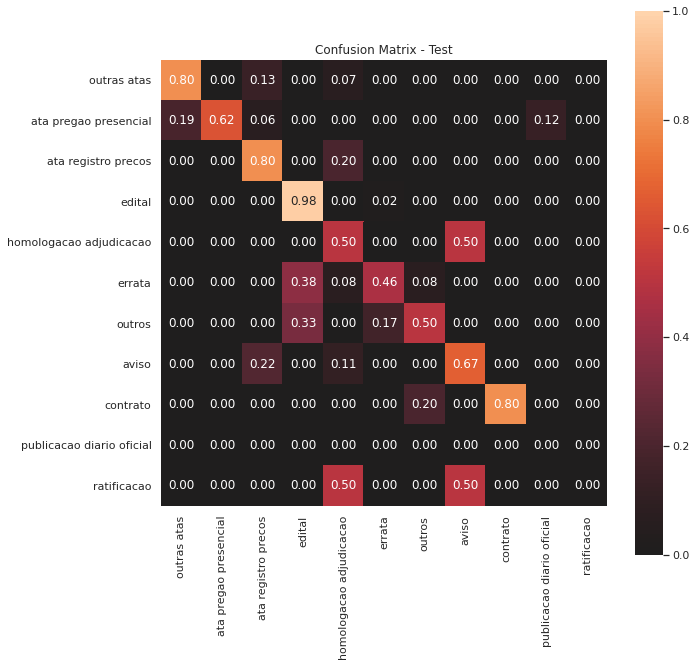

Test:
 loss 0.602, accuracy 0.827, F1-Macro 0.542, F1-Weighted 0.827


In [12]:
def main(num_epochs, num_classes):
    set_seed(SEED)
        
    #load_data(df_data)
    config = {
        "embedding_dim": 600,
        "num_layers": 3,
        "dropout": 0.4,
        "lr": 0.00001,
        "num_terms": 300,
        "batch_size": 24,
        "num_epochs": num_epochs,
        "num_classe": None,
        "vocab_size": None
    }
    if num_classes == 13:
        df_data = pd.read_csv("./lstm_data/preprocessed_data_v2.csv")
    else:
        df_data = pd.read_csv("./lstm_data/preprocessed_data.csv")
        
    labels_dict = dict(df_data[['label_int', 'label']].drop_duplicates().values)
    """
    Aqui você pode fazer a definição de qual municipio vai virar conjunto de validação
    """ 
    train, val, _, _ = train_test_split(
            df_data.loc[df_data["fold"] == "val"],
            df_data.loc[df_data["fold"] == "val",'label_int'],
            test_size=50,
            random_state=SEED,
            stratify=df_data.loc[df_data["fold"] == "val",'label_int'],
        )

    train, test, _, _ = train_test_split(
            df_data.loc[df_data["fold"] == "test"],
            df_data.loc[df_data["fold"] == "test",'label_int'],
            test_size=50,
            random_state=SEED,
            stratify=df_data.loc[df_data["fold"] == "test",'label_int'],
        )

    df_data.loc[test.index, "fold"] = "train"

    df_data.loc[val.index, "fold"] = "train"
    
    df_data, vocab_size, vocab2index = encode_data(df_data, config)
       
    config.update({
        "num_classes": df_data['label'].nunique(),
        "vocab_size": vocab_size
    })
    
    data_loaders = data_load(config, df_data)
    
    embedding_matrix=create_embedding_matrix(vocab2index,dimension=600)
    
    best_model = train_model(config, checkpoint_dir="./lstm_data/models/", data_loaders=data_loaders, embedding_matrix=embedding_matrix)
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    best_model.to(device)
    
    print("="*20, "BEST MODEL", "="*20)
    train_metrics = eval_model(best_model, data_loaders["train"], fold = "train", labels_dict = labels_dict, device=device)
    print("Train:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]))
    
    val_metrics = eval_model(best_model, data_loaders["val"], fold = "Val", labels_dict = labels_dict, device=device)
    print("Val:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]))

    test_metrics = eval_model(best_model, data_loaders["test"], fold = "Test", labels_dict = labels_dict, device=device)
    print("Test:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3]))
    
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_epochs=50, num_classes=13)

# Todos documentos
### 21 classes
==================== BEST MODEL ====================<br/>
Val:<br/>
 loss 0.127, accuracy 0.973, F1-Macro 0.936, F1-Weighted 0.972<br/>
Test:<br/>
 loss 0.139, accuracy 0.966, F1-Macro 0.942, F1-Weighted 0.966<br/>
 
### 13 classes
==================== BEST MODEL ====================<br/>
Val:<br/>
 loss 0.118, accuracy 0.970, F1-Macro 0.953, F1-Weighted 0.970<br/>
Test:<br/>
 loss 0.169, accuracy 0.970, F1-Macro 0.955, F1-Weighted 0.970<br/>

# 10% dos documentos dos municípios foram usados para treinamento
# Val: Pirapetinga
# Test: São Bento Abade
 
### 13 classes
==================== BEST MODEL ====================<br/>
Train:<br/>
 loss 0.121, accuracy 0.966, F1-Macro 0.930, F1-Weighted 0.966<br/>
Val:<br/>
 loss 0.391, accuracy 0.888, F1-Macro 0.670, F1-Weighted 0.892<br/>
Test:<br/>
 loss 1.000, accuracy 0.782, F1-Macro 0.476, F1-Weighted 0.766<br/>